やりたいこと

・引ける牌の確率が変わったとき（手牌にある牌はその分引きづらくなるとか）のvalueを求める

・18種や27種（マンズだけでなく、ピンズやソーズも増やす）時のvalueを求める

面倒なので、まずは最大でも１色とする(n<=9)、手牌は14枚以下(m=3, 5, 8, 11, 14のみ)、同一牌は4枚(l = 4)でこれは固定。この条件でvalueを求める。



 **変数の意味**

- state : あがりに必要な枚数の手牌の状態

- hand : stateから一枚切った状態

### 必要な関数の再定義

In [1]:
from collections import defaultdict
def is_valid(seq, l=4): # 生成された組み合わせが手牌として妥当かどうかを判断する関数　tuple(seq)の一つ一つが一つの状態(手牌)に対応している
    counts = defaultdict(lambda: 0)
    for i in range(0, len(seq)):
        if i + 1 < len(seq) and seq[i] > seq[i + 1]: # 前半の条件はiが一番最後以外は常に成立、後半の条件は昇順に整列するための条件
            return False
        counts[seq[i]] += 1
        if (counts[seq[i]] > l): return False # 牌の上限枚数を超えたらFalse
    return True

import itertools
def number_state_slow(n,m,l): # 全ての手牌の組み合わせの数を出力する関数
    count = 0
    for seq in itertools.product(range(n), repeat = m): # 直積を作る関数, n=9 m=5 なら 9 ** 5 回繰り返す　
        if is_valid(seq,l):
            count += 1
            #print(list(seq))
    return count
    
def generate_all_l(n, m, l=4): # 全ての手牌の組み合わせをタプルで出力する関数
    gen_list = []
    for seq in itertools.product(range(n), repeat = m):
        if is_valid(seq, l):
            gen_list.append(seq)
    return gen_list

def states_to_hist(state_list, n): # 手牌(state)を、牌種ごとの枚数のリスト(長さn)に変換する関数
    hist_list = []
    for state in state_list:
        #print(state)
        ret = [0] * n # ret = [0,0,...,0]
        for c in state:
            ret[c] += 1
        hist_list.append(ret)
    return hist_list

def hand_to_prob_and_state(hand, state_nml, n, m, l=4): # ある手牌(hand)における、1枚ツモる時の遷移確率(prob)と手牌(state)のindexのタプルを出す関数
    #print(state_nml)
    ret = [l] * n  #  残り枚数を表すリスト
    for h in hand:
        ret[h] -= 1
    yama_sum = n * l - (m - 1)
    state_list = []
    for i in range(n):
        if ret[i] == 0: 
            continue
        prob = ret[i] / yama_sum # 遷移確率
        state = tuple(sorted(list(hand) + [i])) # 遷移後の手牌
        #print(state)
        state_index = state_nml.index(state) # 遷移後の手牌のindex
        #print(state_index)
        state_list.append((prob, state_index))
    return state_list

def state_to_hand(state): # ある手牌stateに遷移できるhandを出力する関数
    return list(set(tuple(state[:i] + state[i+1:]) for i in range(len(state)))) # i番目の要素を取り除く

def is_win_sub(hist, two, three):
    if any(x < 0 for x in hist):
        return False # この行を消したかったら、順子判定のところで手牌の枚数が負になるものを弾いておく
    if two == 0 and three == 0:
        return True
    i = next(i for i, x in enumerate(hist) if x > 0) # histの中でx>０を満たす最小のindexを持ってくる
    if two > 0 and hist[i] >= 2 and is_win_sub([x - 2 if i == j else x for j, x in enumerate(hist)], two - 1, three): # 雀頭
        return True
    if three > 0 and hist[i] >= 3 and is_win_sub([x - 3 if i == j else x for j, x in enumerate(hist)], two, three - 1): # 刻子
        return True
    if three > 0 and i + 2 < len(hist) and is_win_sub([x -1 if i <= j <= i + 2 else x for j, x in enumerate(hist)], two, three - 1): # 順子
        return True
    return False

def is_win_main(hist):
    n_two = 1 if sum(hist) % 3 == 2 else 0
    n_three = sum(hist) // 3
    return is_win_sub(hist, n_two, n_three)

def value_iteration(n, m, l, gamma):
    state_nml = generate_all_l(n, m, l)
    hand_nml = generate_all_l(n, m-1, l)
    hist_nml = states_to_hist(state_nml, n)
    is_win_nml = [is_win_main(hist) for hist in hist_nml]
    h2ps_nml = [hand_to_prob_and_state(hand, state_nml, n, m, l) for hand in hand_nml]
    s2h_nml = [[hand_nml.index(hand) for hand in state_to_hand(state)] for state in state_nml]
    value_hand = [0] * len(hand_nml)
    n_hand = len(hand_nml)
    value_state = [1 if is_win_nml[i] else 0 for i in range(len(state_nml))] # あがっていればvalueは1、いなければ0
    n_state = len(state_nml)
    theta = 1e-6
    while True:
        print('iteration')
        delta = 0
        for i in range(n_hand):
            old_v = value_hand[i]
            value_hand[i] = sum(p * value_state[n] for (p, n) in h2ps_nml[i])
            delta = max(delta, abs(old_v - value_hand[i]))
        if delta < theta: break
        for i in range(n_state):
            if is_win_nml[i]: continue
            value_state[i] = max(gamma * value_hand[n] for n in s2h_nml[i])
    return value_hand

### ニューラルネットの学習

In [0]:
import numpy as np
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import random
from tensorflow import keras
from tensorflow.keras import layers

random_seed = 34
np.random.seed(random_seed)
tf.set_random_seed(random_seed)

In [0]:
def one_hot_vector1(hands, n): # 手牌の中の牌一つ一つをone-hotにした(手牌１つがn * m-1の行列に対応)
    results = np.zeros((len(hands), n, len(hands[0])))
    for i in range(len(hands)):
        for j, hand_i in enumerate(hands[i]):
            results[i][hand_i][j] = 1
    return results

def one_hot_vector2(hands, n): # 手牌の中の牌一つ一つをone-hotにした(手牌１つがm-1 * nの行列に対応) one_hot_vector1の転置
    results = np.zeros((len(hands), len(hands[0]), n))
    for i in range(len(hands)):
        for j, hand_i in enumerate(hands[i]):
            results[i][j][hand_i] = 1
    return results

def one_hot_vector3(hists, n, l=4): # histをそのままone-hotにした(手牌１つがn * l + 1の行列に対応)
    results = np.zeros((len(hists), n, l + 1))
    for i in range(len(hists)):
        for j, hist_i in enumerate(hists[i]):
            results[i][j][hist_i] = 1
    return results

def one_hot_vector4(hists, n, l=4): # 上に近いけど、持ってる枚数より小さい数も1で埋めた(手牌１つがn * lの行列に対応)
    results = np.zeros((len(hists), n, l))
    for i in range(len(hists)):
        for j, hist_i in enumerate(hists[i]):
            if hist_i == 0:
                continue
            else:
                results[i][j][:hist_i] = 1
    return results

example_hands = [[0, 1, 1, 5], [3, 3, 6, 7]]
example_hists = states_to_hist(example_hands, 9)
print(1, '\n', one_hot_vector1(example_hands, 9), '\n')
print(2, '\n', one_hot_vector2(example_hands, 9), '\n')
print(3, '\n', one_hot_vector3(example_hists, 9), '\n')
print(4, '\n', one_hot_vector4(example_hists, 9), '\n')

n = 9
m = 5
l = 4

value_hand_nml = value_iteration(n, m, l, 0.9)
hand_nml = generate_all_l(n, m - 1, l)
one_hot_hand_nml1 = one_hot_vector1(hand_nml, n)
one_hot_hand_nml2 = one_hot_vector2(hand_nml, n)

hist_nml = states_to_hist(hand_nml, n) # handをhistのリストに変換
one_hot_hand_nml3 = one_hot_vector3(hist_nml, n, l)
one_hot_hand_nml4 = one_hot_vector4(hist_nml, n, l)
#print(one_hot_hand_nml1.shape)
#print(len(value_hand_nml))

1 
 [[[1. 0. 0. 0.]
  [0. 1. 1. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 1.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]]

 [[0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [1. 1. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 1. 0.]
  [0. 0. 0. 1.]
  [0. 0. 0. 0.]]] 

2 
 [[[1. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 1. 0. 0. 0. 0. 0. 0. 0.]
  [0. 1. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 1. 0. 0. 0.]]

 [[0. 0. 0. 1. 0. 0. 0. 0. 0.]
  [0. 0. 0. 1. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 1. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 1. 0.]]] 

3 
 [[[0. 1. 0. 0. 0.]
  [0. 0. 1. 0. 0.]
  [1. 0. 0. 0. 0.]
  [1. 0. 0. 0. 0.]
  [1. 0. 0. 0. 0.]
  [0. 1. 0. 0. 0.]
  [1. 0. 0. 0. 0.]
  [1. 0. 0. 0. 0.]
  [1. 0. 0. 0. 0.]]

 [[1. 0. 0. 0. 0.]
  [1. 0. 0. 0. 0.]
  [1. 0. 0. 0. 0.]
  [0. 0. 1. 0. 0.]
  [1. 0. 0. 0. 0.]
  [1. 0. 0. 0. 0.]
  [0. 1. 0. 0. 0.]
  [0. 1. 0. 0. 0.]
  [1. 0. 0. 0. 0.]]] 

4 
 [[[1. 0. 0. 0.]
  [1. 1. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [1. 0.

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_3 (Flatten)          (None, 36)                0         
_________________________________________________________________
dense_9 (Dense)              (None, 30)                1110      
_________________________________________________________________
dense_10 (Dense)             (None, 10)                310       
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 11        
Total params: 1,431
Trainable params: 1,431
Non-trainable params: 0
_________________________________________________________________

..................................................
..................................................
..................................................
..................................................
..................................................
................

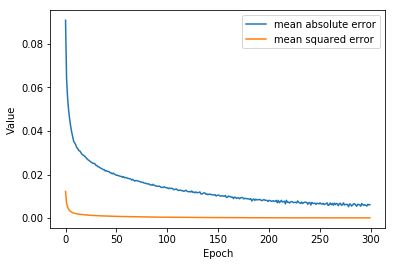

In [0]:
# one_host_hand_nml1
def build_model():
    model = keras.Sequential([
        layers.Flatten(input_shape=(n, m - 1)),
        layers.Dense(30, activation='relu'),
        layers.Dense(10, activation='relu'),
        #layers.Dense(15, activation='relu'),
        #layers.Dropout(rate=0.5),
        layers.Dense(1,activation='sigmoid')
    ])

    optimizer = keras.optimizers.RMSprop(0.001)

    model.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['mean_absolute_error', 'mean_squared_error'])
    return model

model = build_model()
model.summary()

# エポックが終わるごとにドットを一つ出力することで進捗を表示
class PrintDot(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        if epoch % 50 == 0: print('')
        print('.', end='')

EPOCHS = 300

history = model.fit(one_hot_hand_nml1, value_hand_nml, epochs=EPOCHS, validation_split = 0, verbose=0, callbacks=[PrintDot()])

hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
print('\n',hist.tail())

import matplotlib.pyplot as plt

def plot_history(history):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch

    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Value')
    plt.plot(hist['epoch'], hist['mean_absolute_error'], label='mean absolute error')
    plt.plot(hist['epoch'], hist['mean_squared_error'], label = 'mean squared error')
    plt.legend()

plot_history(history)

predictions1 = model.predict(one_hot_hand_nml1)

300epochで、mean_absolute_errorは0.033~0.035程度である

In [0]:
for i, hand in enumerate(hand_nml):
    print('hand {}  predict value {:.6f}  true value {:.6f}'.format(hand, predictions1[i][0], value_hand_nml[i]))

hand (0, 0, 0, 0)  predict value 0.616948  true value 0.623207
hand (0, 0, 0, 1)  predict value 0.737679  true value 0.736842
hand (0, 0, 0, 2)  predict value 0.746848  true value 0.745743
hand (0, 0, 0, 3)  predict value 0.680991  true value 0.674165
hand (0, 0, 0, 4)  predict value 0.680798  true value 0.683535
hand (0, 0, 0, 5)  predict value 0.684301  true value 0.683535
hand (0, 0, 0, 6)  predict value 0.686601  true value 0.683535
hand (0, 0, 0, 7)  predict value 0.675724  true value 0.671090
hand (0, 0, 0, 8)  predict value 0.656980  true value 0.661170
hand (0, 0, 1, 1)  predict value 0.649153  true value 0.637316
hand (0, 0, 1, 2)  predict value 0.705021  true value 0.697673
hand (0, 0, 1, 3)  predict value 0.678719  true value 0.669670
hand (0, 0, 1, 4)  predict value 0.623511  true value 0.621600
hand (0, 0, 1, 5)  predict value 0.629028  true value 0.626149
hand (0, 0, 1, 6)  predict value 0.638537  true value 0.631045
hand (0, 0, 1, 7)  predict value 0.613662  true value 0

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_2 (Flatten)          (None, 36)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 30)                1110      
_________________________________________________________________
dense_6 (Dense)              (None, 10)                310       
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 11        
Total params: 1,431
Trainable params: 1,431
Non-trainable params: 0
_________________________________________________________________

..................................................
..................................................
..................................................
..................................................
.............................................

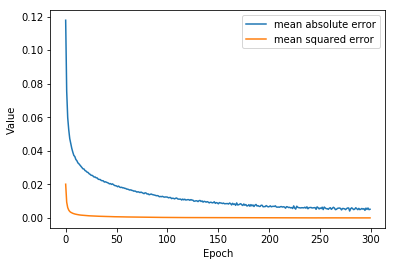

In [0]:
# one_host_hand_nml2
def build_model2():
    model = keras.Sequential([
        layers.Flatten(input_shape=(m - 1, n)),
        layers.Dense(30, activation='relu'),
        layers.Dense(10, activation='relu'),
        #layers.Dense(15, activation='relu'),
        #layers.Dropout(rate=0.5),
        layers.Dense(1,activation='sigmoid')
    ])

    optimizer = keras.optimizers.RMSprop(0.001)

    model.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['mean_absolute_error', 'mean_squared_error'])
    return model

model = build_model2()
model.summary()

# エポックが終わるごとにドットを一つ出力することで進捗を表示
class PrintDot(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        if epoch % 50 == 0: print('')
        print('.', end='')

EPOCHS = 300

history = model.fit(one_hot_hand_nml2, value_hand_nml, epochs=EPOCHS, validation_split = 0, verbose=0, callbacks=[PrintDot()])

hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
print('\n',hist.tail())

plot_history(history)

predictions2 = model.predict(one_hot_hand_nml2)

300epochで、mean_absolute_errorは0.041~0.039程度である

In [0]:
for i, hand in enumerate(hand_nml):
    print('hand {}  predict value {:.6f}  true value {:.6f}'.format(hand, predictions2[i][0], value_hand_nml[i]))

hand (0, 0, 0, 0)  predict value 0.637653  true value 0.623207
hand (0, 0, 0, 1)  predict value 0.671378  true value 0.736842
hand (0, 0, 0, 2)  predict value 0.700769  true value 0.745743
hand (0, 0, 0, 3)  predict value 0.704287  true value 0.674165
hand (0, 0, 0, 4)  predict value 0.691330  true value 0.683535
hand (0, 0, 0, 5)  predict value 0.685119  true value 0.683535
hand (0, 0, 0, 6)  predict value 0.676142  true value 0.683535
hand (0, 0, 0, 7)  predict value 0.656813  true value 0.671090
hand (0, 0, 0, 8)  predict value 0.629353  true value 0.661170
hand (0, 0, 1, 1)  predict value 0.658167  true value 0.637316
hand (0, 0, 1, 2)  predict value 0.687558  true value 0.697673
hand (0, 0, 1, 3)  predict value 0.691076  true value 0.669670
hand (0, 0, 1, 4)  predict value 0.678119  true value 0.621600
hand (0, 0, 1, 5)  predict value 0.671908  true value 0.626149
hand (0, 0, 1, 6)  predict value 0.662931  true value 0.631045
hand (0, 0, 1, 7)  predict value 0.643603  true value 0

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_3 (Flatten)          (None, 45)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 15)                690       
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 16        
Total params: 706
Trainable params: 706
Non-trainable params: 0
_________________________________________________________________

..................................................
..................................................
..................................................
..................................................
..................................................
..................................................
          loss  mean_absolute_error  mean_squared_error  epoch
295  0.000218   

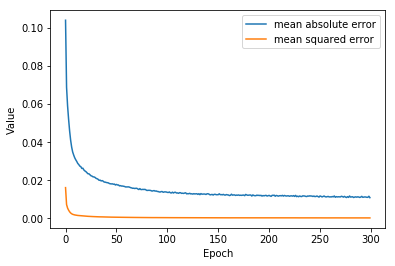

In [0]:
# one_host_hand_nml3
def build_model3():
    model = keras.Sequential([
        layers.Flatten(input_shape=(n, l + 1)),
        layers.Dense(15, activation='relu'),
        layers.Dense(1,activation='sigmoid')
    ])

    optimizer = keras.optimizers.RMSprop(0.001)

    model.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['mean_absolute_error', 'mean_squared_error'])
    return model

model = build_model3()
model.summary()

# エポックが終わるごとにドットを一つ出力することで進捗を表示
class PrintDot(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        if epoch % 50 == 0: print('')
        print('.', end='')

EPOCHS = 300

history = model.fit(one_hot_hand_nml3, value_hand_nml, epochs=EPOCHS, validation_split = 0, verbose=0, callbacks=[PrintDot()])

hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
print('\n',hist.tail())

plot_history(history)

predictions3 = model.predict(one_hot_hand_nml3)

300epochで、mean_absolute_errorは0.035~0.033程度である

In [0]:
for i, hand in enumerate(hand_nml):
    print('hand {}  predict value {:.6f}  true value {:.6f}'.format(hand, predictions3[i][0], value_hand_nml[i]))

hand (0, 0, 0, 0)  predict value 0.627731  true value 0.623207
hand (0, 0, 0, 1)  predict value 0.731954  true value 0.736842
hand (0, 0, 0, 2)  predict value 0.737995  true value 0.745743
hand (0, 0, 0, 3)  predict value 0.691888  true value 0.674165
hand (0, 0, 0, 4)  predict value 0.691961  true value 0.683535
hand (0, 0, 0, 5)  predict value 0.688001  true value 0.683535
hand (0, 0, 0, 6)  predict value 0.683817  true value 0.683535
hand (0, 0, 0, 7)  predict value 0.685591  true value 0.671090
hand (0, 0, 0, 8)  predict value 0.661089  true value 0.661170
hand (0, 0, 1, 1)  predict value 0.634639  true value 0.637316
hand (0, 0, 1, 2)  predict value 0.703284  true value 0.697673
hand (0, 0, 1, 3)  predict value 0.671209  true value 0.669670
hand (0, 0, 1, 4)  predict value 0.624923  true value 0.621600
hand (0, 0, 1, 5)  predict value 0.625926  true value 0.626149
hand (0, 0, 1, 6)  predict value 0.634398  true value 0.631045
hand (0, 0, 1, 7)  predict value 0.620223  true value 0

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_6 (Flatten)          (None, 36)                0         
_________________________________________________________________
dense_18 (Dense)             (None, 20)                740       
_________________________________________________________________
dense_19 (Dense)             (None, 10)                210       
_________________________________________________________________
dense_20 (Dense)             (None, 1)                 11        
Total params: 961
Trainable params: 961
Non-trainable params: 0
_________________________________________________________________
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 9, 16)             208       
_________________________________________________________________
flatten_7 (F

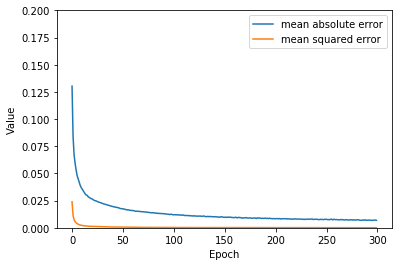

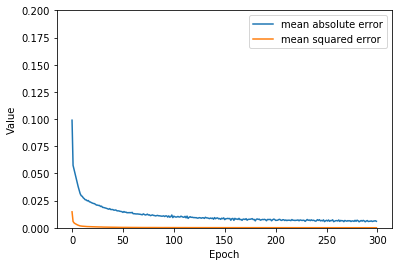

In [0]:
# one_host_hand_nml4
def build_dence_model(): # 比較のためのdenceモデル
    dence_model = keras.Sequential([
        layers.Flatten(input_shape=(n, l)),
        layers.Dense(20, activation='relu'),
        layers.Dense(10, activation='relu'),
        #layers.Dense(15, activation='relu'),
        #layers.Dropout(rate=0.5),
        layers.Dense(1,activation='sigmoid')
    ])

    optimizer = keras.optimizers.RMSprop(0.001)

    dence_model.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['mean_absolute_error',  'mean_squared_error'])
    return dence_model

def build_cnn_model():
    cnn_model = keras.Sequential([
        layers.Conv1D(filters=16, kernel_size=3, strides=1, padding='same',  activation='relu', input_shape=(n, l)),
        #layers.Conv1D(filters=8, kernel_size=1, strides=1, padding='same',  activation='relu'),
        #layers.Conv1D(filters=8, kernel_size=3, strides=1, padding='same',  activation='relu'),
        #layers.Dense(20, activation='relu'),
        layers.Flatten(),
        layers.Dense(10, activation='relu'),
        layers.Dense(10, activation='relu'),
        #layers.Dense(15, activation='relu'),
        #layers.Dropout(rate=0.5),
        layers.Dense(1,activation='sigmoid')
    ])

    optimizer = keras.optimizers.RMSprop(0.001)

    cnn_model.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['mean_absolute_error', 'mean_squared_error'])
    return cnn_model

dence_model = build_dence_model()
cnn_model = build_cnn_model()
dence_model.summary()
cnn_model.summary()

# エポックが終わるごとにドットを一つ出力することで進捗を表示
class PrintDot(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        if epoch % 50 == 0: print('')
        print('.', end='')

EPOCHS = 300

dence_history = dence_model.fit(one_hot_hand_nml4, value_hand_nml, epochs=EPOCHS, validation_split = 0, verbose=0, callbacks=[PrintDot()])
print('Dence終わり')
cnn_history = cnn_model.fit(one_hot_hand_nml4, value_hand_nml, epochs=EPOCHS, validation_split = 0, verbose=0, callbacks=[PrintDot()])
print('CNN終わり')

dence_hist = pd.DataFrame(dence_history.history)
dence_hist['epoch'] = dence_history.epoch
cnn_hist = pd.DataFrame(cnn_history.history)
cnn_hist['epoch'] = cnn_history.epoch
print('\n',dence_hist.tail())
print('\n',cnn_hist.tail())

def plot_history(history):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch

    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Value')
    plt.plot(hist['epoch'], hist['mean_absolute_error'], label='mean absolute error')
    plt.plot(hist['epoch'], hist['mean_squared_error'], label = 'mean squared error')
    plt.legend()
    plt.ylim(0,0.2)


plot_history(dence_history)
plot_history(cnn_history)

dence_predictions = dence_model.predict(one_hot_hand_nml4)
cnn_predictions = cnn_model.predict(one_hot_hand_nml4)

300eopchのmean_absolute_errorは、Denceで0.034 ~ 0.032、CNNで0.032 ~ 0.030程度

In [0]:
for i, hand in enumerate(hand_nml):
    print('hand {}   dence value {:.6f}   cnn value {:.6f}   true value {:.6f}'.format(hand, dence_predictions[i][0], cnn_predictions[i][0], value_hand_nml[i]))

hand (0, 0, 0, 0)   dence value 0.611006   cnn value 0.636246   true value 0.623207
hand (0, 0, 0, 1)   dence value 0.733441   cnn value 0.738281   true value 0.736842
hand (0, 0, 0, 2)   dence value 0.736357   cnn value 0.752505   true value 0.745743
hand (0, 0, 0, 3)   dence value 0.671703   cnn value 0.676430   true value 0.674165
hand (0, 0, 0, 4)   dence value 0.675021   cnn value 0.698414   true value 0.683535
hand (0, 0, 0, 5)   dence value 0.678351   cnn value 0.685275   true value 0.683535
hand (0, 0, 0, 6)   dence value 0.671352   cnn value 0.706242   true value 0.683535
hand (0, 0, 0, 7)   dence value 0.663742   cnn value 0.684757   true value 0.671090
hand (0, 0, 0, 8)   dence value 0.652191   cnn value 0.661353   true value 0.661170
hand (0, 0, 1, 1)   dence value 0.634237   cnn value 0.650742   true value 0.637316
hand (0, 0, 1, 2)   dence value 0.706952   cnn value 0.709680   true value 0.697673
hand (0, 0, 1, 3)   dence value 0.673473   cnn value 0.673208   true value 0

### 手牌の数を3枚増やして8枚にする

In [0]:
n = 9
m = 8 # 手牌を8枚にする
l = 4

value_hand_nml = value_iteration(n, m, l, 0.9)
hand_nml = generate_all_l(n, m - 1, l)
one_hot_hand_nml1 = one_hot_vector1(hand_nml, n)
one_hot_hand_nml2 = one_hot_vector2(hand_nml, n)

hist_nml = states_to_hist(hand_nml, n) # handをhistのリストに変換
one_hot_hand_nml3 = one_hot_vector3(hist_nml, n, l)
one_hot_hand_nml4 = one_hot_vector4(hist_nml, n, l)

iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_8 (Flatten)          (None, 36)                0         
_________________________________________________________________
dense_24 (Dense)             (None, 20)                740       
_________________________________________________________________
dense_25 (Dense)             (None, 10)                210       
_________________________________________________________________
dense_26 (Dense)             (None, 1)                 11        
Total params: 961
Trainable params: 961
Non-trainable params: 0
_________________________________________________________________
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_2 (Conv1D)            (None, 9, 16)             208       
_________________________________________________________________
flatten_9 (F

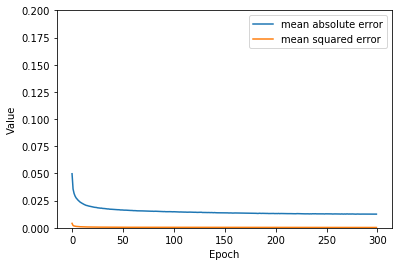

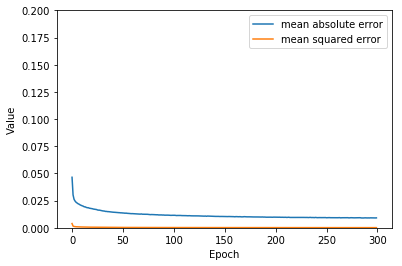

In [0]:
def build_dence_model(): # 比較のためのdenceモデル
    dence_model = keras.Sequential([
        layers.Flatten(input_shape=(n, l)),
        layers.Dense(20, activation='relu'),
        layers.Dense(10, activation='relu'),
        #layers.Dense(15, activation='relu'),
        #layers.Dropout(rate=0.5),
        layers.Dense(1,activation='sigmoid')
    ])

    optimizer = keras.optimizers.RMSprop(0.001)

    dence_model.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['mean_absolute_error',  'mean_squared_error'])
    return dence_model

def build_cnn_model():
    cnn_model = keras.Sequential([
        layers.Conv1D(filters=16, kernel_size=3, strides=1, padding='same',  activation='relu', input_shape=(n, l)),
        #layers.Conv1D(filters=8, kernel_size=1, strides=1, padding='same',  activation='relu'),
        #layers.Conv1D(filters=8, kernel_size=3, strides=1, padding='same',  activation='relu'),
        #layers.Dense(20, activation='relu'),
        layers.Flatten(),
        layers.Dense(10, activation='relu'),
        layers.Dense(10, activation='relu'),
        #layers.Dense(15, activation='relu'),
        #layers.Dropout(rate=0.5),
        layers.Dense(1,activation='sigmoid')
    ])

    optimizer = keras.optimizers.RMSprop(0.001)

    cnn_model.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['mean_absolute_error',  'mean_squared_error'])
    return cnn_model

dence_model = build_dence_model()
cnn_model = build_cnn_model()
dence_model.summary()
cnn_model.summary()

# エポックが終わるごとにドットを一つ出力することで進捗を表示
class PrintDot(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        if epoch % 50 == 0: print('')
        print('.', end='')

EPOCHS = 300

dence_history = dence_model.fit(one_hot_hand_nml4, value_hand_nml, epochs=EPOCHS, validation_split = 0, verbose=0, callbacks=[PrintDot()])
print('Dence終わり')
cnn_history = cnn_model.fit(one_hot_hand_nml4, value_hand_nml, epochs=EPOCHS, validation_split = 0, verbose=0, callbacks=[PrintDot()])
print('CNN終わり')

dence_hist = pd.DataFrame(dence_history.history)
dence_hist['epoch'] = dence_history.epoch
cnn_hist = pd.DataFrame(cnn_history.history)
cnn_hist['epoch'] = cnn_history.epoch
print('\n',dence_hist.tail())
print('\n',cnn_hist.tail())

plot_history(dence_history)
plot_history(cnn_history)

dence_predictions = dence_model.predict(one_hot_hand_nml4)
cnn_predictions = cnn_model.predict(one_hot_hand_nml4)

In [0]:
for i, hand in enumerate(hand_nml):
    print('hand {}   dence value {:.6f}   cnn value {:.6f}   true value {:.6f}'.format(hand, dence_predictions[i][0], cnn_predictions[i][0], value_hand_nml[i]))

hand (0, 0, 0, 0, 1, 1, 1)   dence value 0.681877   cnn value 0.689366   true value 0.697337
hand (0, 0, 0, 0, 1, 1, 2)   dence value 0.706484   cnn value 0.710999   true value 0.724631
hand (0, 0, 0, 0, 1, 1, 3)   dence value 0.643887   cnn value 0.637870   true value 0.654518
hand (0, 0, 0, 0, 1, 1, 4)   dence value 0.637125   cnn value 0.640731   true value 0.651995
hand (0, 0, 0, 0, 1, 1, 5)   dence value 0.635188   cnn value 0.642255   true value 0.656851
hand (0, 0, 0, 0, 1, 1, 6)   dence value 0.627171   cnn value 0.648018   true value 0.659891
hand (0, 0, 0, 0, 1, 1, 7)   dence value 0.620282   cnn value 0.628638   true value 0.634604
hand (0, 0, 0, 0, 1, 1, 8)   dence value 0.603292   cnn value 0.615622   true value 0.612079
hand (0, 0, 0, 0, 1, 2, 2)   dence value 0.724581   cnn value 0.703017   true value 0.724631
hand (0, 0, 0, 0, 1, 2, 3)   dence value 0.714287   cnn value 0.730219   true value 0.741486
hand (0, 0, 0, 0, 1, 2, 4)   dence value 0.691613   cnn value 0.701371

hand (1, 1, 1, 1, 3, 3, 7)   dence value 0.660845   cnn value 0.647244   true value 0.659139
hand (1, 1, 1, 1, 3, 3, 8)   dence value 0.639698   cnn value 0.631546   true value 0.641136
hand (1, 1, 1, 1, 3, 4, 4)   dence value 0.704060   cnn value 0.677009   true value 0.700762
hand (1, 1, 1, 1, 3, 4, 5)   dence value 0.723618   cnn value 0.714554   true value 0.729946
hand (1, 1, 1, 1, 3, 4, 6)   dence value 0.666262   cnn value 0.659385   true value 0.672482
hand (1, 1, 1, 1, 3, 4, 7)   dence value 0.644013   cnn value 0.640973   true value 0.649454
hand (1, 1, 1, 1, 3, 4, 8)   dence value 0.632811   cnn value 0.628685   true value 0.645953
hand (1, 1, 1, 1, 3, 5, 5)   dence value 0.698853   cnn value 0.687268   true value 0.707161
hand (1, 1, 1, 1, 3, 5, 6)   dence value 0.668062   cnn value 0.664360   true value 0.680430
hand (1, 1, 1, 1, 3, 5, 7)   dence value 0.643902   cnn value 0.638388   true value 0.648532
hand (1, 1, 1, 1, 3, 5, 8)   dence value 0.614362   cnn value 0.615450

hand (3, 4, 5, 5, 7, 7, 8)   dence value 0.650826   cnn value 0.660295   true value 0.665917
hand (3, 4, 5, 5, 7, 8, 8)   dence value 0.686026   cnn value 0.665147   true value 0.705467
hand (3, 4, 5, 5, 8, 8, 8)   dence value 0.778015   cnn value 0.766374   true value 0.762782
hand (3, 4, 5, 6, 6, 6, 6)   dence value 0.791704   cnn value 0.785359   true value 0.795773
hand (3, 4, 5, 6, 6, 6, 7)   dence value 0.815522   cnn value 0.863393   true value 0.903226
hand (3, 4, 5, 6, 6, 6, 8)   dence value 0.793223   cnn value 0.807052   true value 0.825959
hand (3, 4, 5, 6, 6, 7, 7)   dence value 0.758783   cnn value 0.729446   true value 0.737155
hand (3, 4, 5, 6, 6, 7, 8)   dence value 0.746697   cnn value 0.744740   true value 0.753880
hand (3, 4, 5, 6, 6, 8, 8)   dence value 0.761308   cnn value 0.731773   true value 0.749083
hand (3, 4, 5, 6, 7, 7, 7)   dence value 0.855531   cnn value 0.911759   true value 0.934066
hand (3, 4, 5, 6, 7, 7, 8)   dence value 0.742056   cnn value 0.708178